#**Preprocessing and clustering 3k PBMCs**

Tutorial: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

PBMC: Periferal Blood Mononuclear Cells (lymphocytes - T cells, B cells, NK cells - and monocytes). 

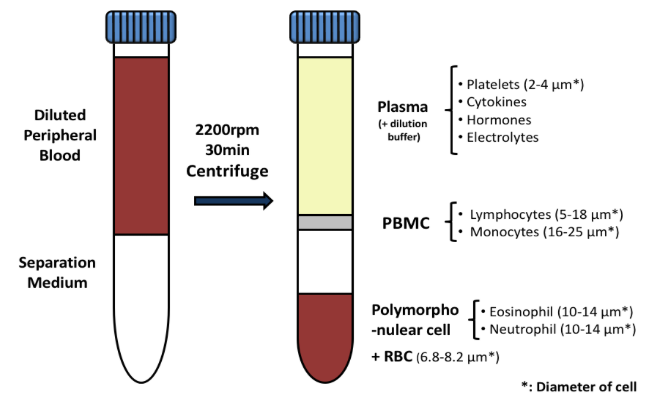

In May 2017, this started out as a demonstration that Scanpy would allow to reproduce most of Seurat’s [guided clustering tutorial](https://satijalab.org/seurat/articles/pbmc3k_tutorial.html) (Satija et al., 2015).

The data consist of 3k PBMCs from a Healthy Donor and are freely available from 10x Genomics. 

In [1]:
%cd /content/drive/MyDrive/Vanessa-Leiko-AP2/Scanpy

/content/drive/MyDrive/Vanessa-Leiko-AP2/Scanpy


In [2]:
!pwd

/content/drive/MyDrive/Vanessa-Leiko-AP2/Scanpy


In [3]:
# download dataset
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O pbmc3k_filtered_gene_bc_matrices.tar.gz

--2021-06-09 12:39:17--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2021-06-09 12:39:17--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘pbmc3k_filtered_gene_bc_matrices.tar.gz’

pbmc3k_filtered_gen 100%[===================>]   7.27M  46.3MB/s    in 0.2s    

2021-06-09 12:39:17 (46.3 MB/s) - ‘pbmc3k_filtered_gene_bc_matrices.tar.gz’

In [4]:
# unpack dataset
!tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

In [ ]:
!pip install scanpy

In [7]:
# import libraries
import numpy as np
import pandas as pd
import scanpy as sc

In [9]:
# verbosity: errors(0), warnings(1), info(2), hints(3)
sc.settings.verbosity = 3

# versions that might influence the numerical results
sc.logging.print_header()

# set resolution/size, styling and format of figures
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.19.5 scipy==1.4.1 pandas==1.1.5 scikit-learn==0.22.2.post1 statsmodels==0.10.2


In [11]:
# file that will store the analysis results
results_file = "pbmc3k.h5ad"

In [10]:
adata = sc.read_10x_mtx("/content/drive/MyDrive/Vanessa-Leiko-AP2/Scanpy/filtered_gene_bc_matrices/hg19/",
                        var_names="gene_symbols", cache=True)

... writing an h5ad cache file to speedup reading next time


In [12]:
# this is unnecessary if using var_names="gene_ids" in sc.read_10x_mtx
adata.var_names_make_unique()

In [13]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

#**1 Preprocessing**

Show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


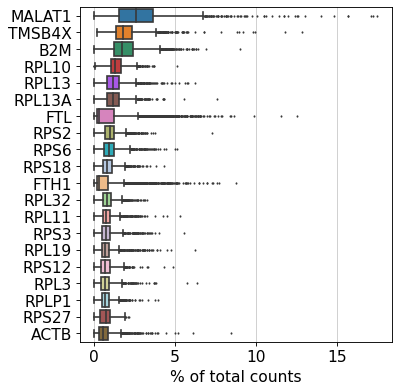

In [14]:
sc.pl.highest_expr_genes(adata, n_top=20)

Basic filtering:

In [15]:
# Filter cell outliers based on counts and numbers of genes expressed.
sc.pp.filter_cells(adata, min_genes=200)

# Filter genes based on number of cells or counts.
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


Let’s assemble some information about mitochondrial genes, which are important for quality control.

Citing from “Simple Single Cell” workflows (Lun, McCarthy & Marioni, 2017):

High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

With pp.calculate_qc_metrics, we can compute many metrics very efficiently.

In [16]:
# annotate the group of mitochondrial genes as 'mt'
adata.var["mt"] = adata.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

A violin plot of some of the computed quality measures:

- the number of genes expressed in the count matrix
- the total counts per cell
- the percentage of counts in mitochondrial genes


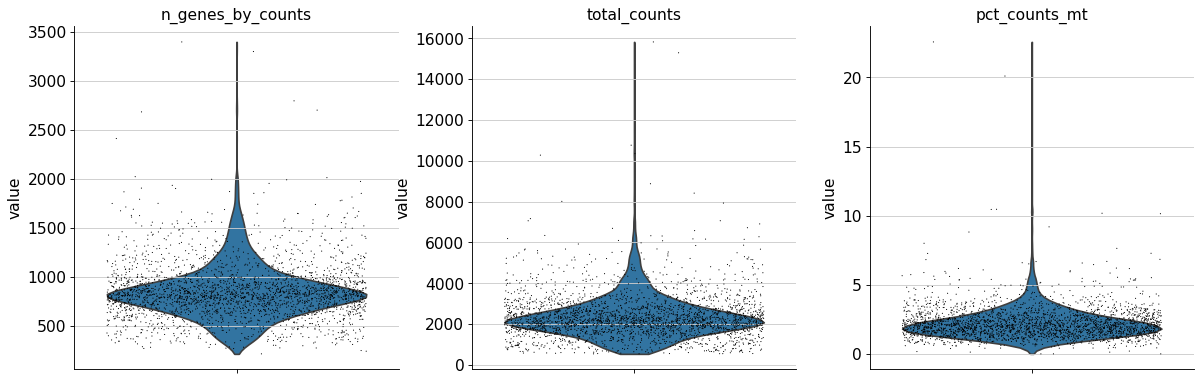

In [17]:
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts:

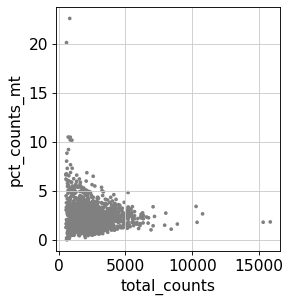

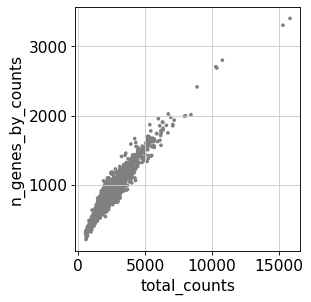

In [18]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

Actually do the filtering by slicing the AnnData object.

In [19]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells.

In [20]:
sc.pp.normalize_total(adata, target_sum=1e4)

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)


Logarithmize the data:

In [21]:
sc.pp.log1p(adata)

Identify highly-variable genes.

In [22]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


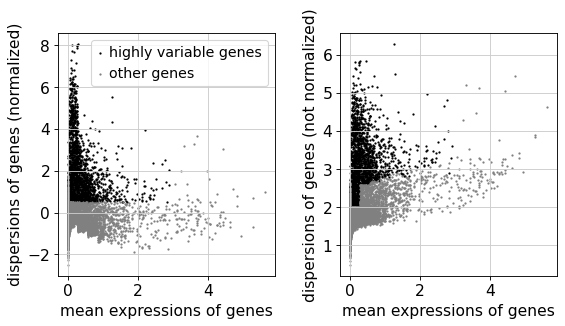

In [23]:
sc.pl.highly_variable_genes(adata)

Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

You can get back an AnnData of the object in .raw by calling .raw.to_adata().

In [24]:
adata.raw = adata

If you don’t proceed below with correcting the data with sc.pp.regress_out and scaling it via sc.pp.scale, you can also get away without using .raw at all.

The result of the previous highly-variable-genes detection is stored as an annotation in .var.highly_variable and auto-detected by PCA and hence, sc.pp.neighbors and subsequent manifold/graph tools. In that case, the step actually do the filtering below is unnecessary, too.

Actually do the filtering

In [25]:
adata = adata[:, adata.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [26]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
    finished (0:00:06)


In [27]:
sc.pp.scale(adata, max_value=10)

#**2 PCA**

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [28]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


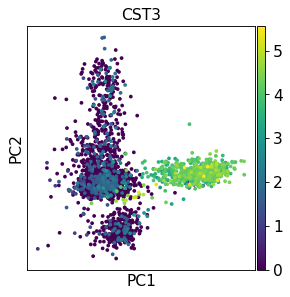

In [36]:
sc.pl.pca(adata, color="CST3")

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() or tSNE sc.tl.tsne(). In our experience, often a rough estimate of the number of PCs does fine.



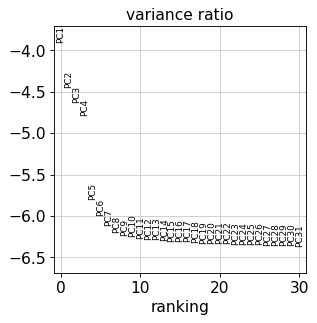

In [37]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result

In [38]:
adata.write(results_file)

In [39]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

#**3 Computing the neighborhood graph**

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat’s results, let’s take the following values.

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [40]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


#**4 Embedding the neighborhood graph**

We suggest embedding the graph in two dimensions using UMAP (McInnes et al., 2018), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```


In [41]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


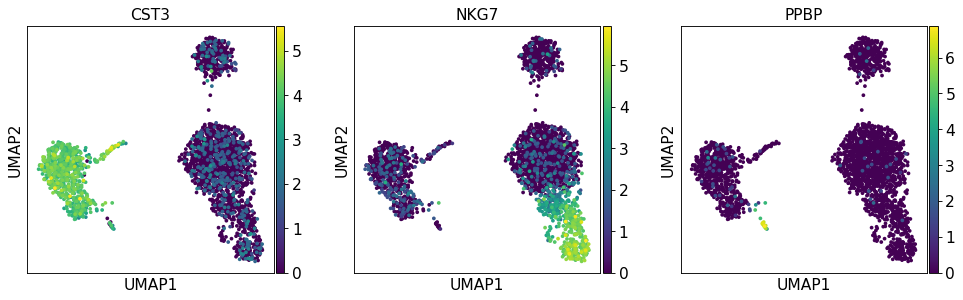

In [42]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"])

As we set the .raw attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to use .raw.

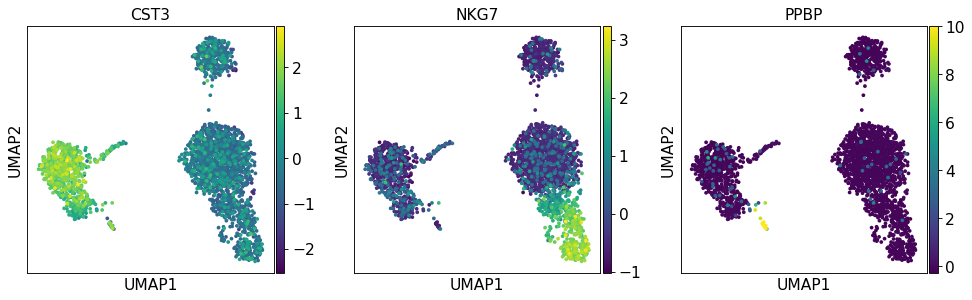

In [43]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], use_raw=False)

#**4 Clustering the neighborhood graph**

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by Traag *et al.* (2018). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [ ]:
!pip install leidenalg

In [47]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the clusters, which agree quite well with the result of Seurat.

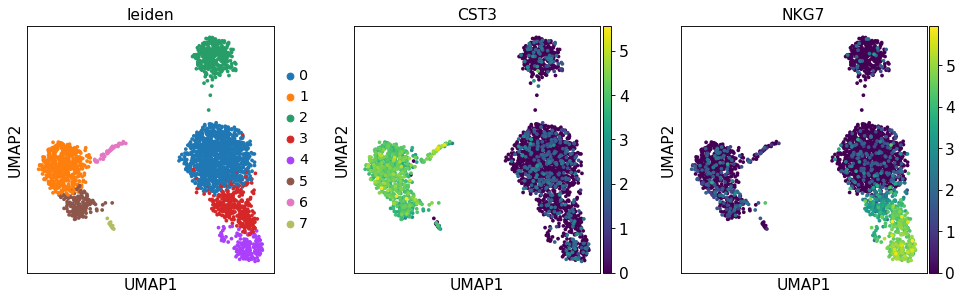

In [48]:
sc.pl.umap(adata, color=["leiden", "CST3", "NKG7"])

Save the result

In [49]:
adata.write(results_file)

#**6 Finding marker genes**

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


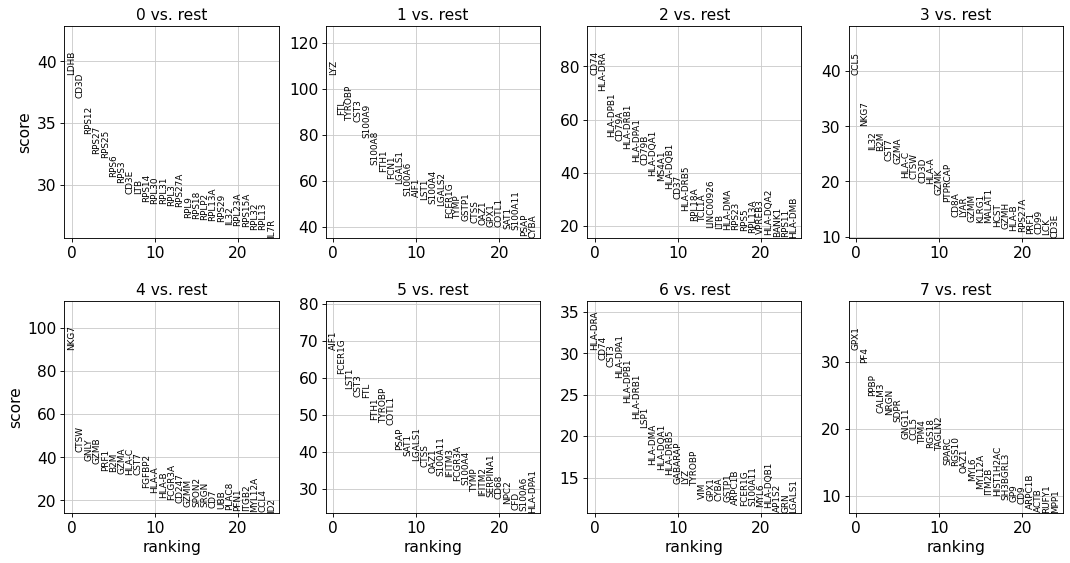

In [50]:
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [51]:
# reduce verbosity
sc.settings.verbosity = 2 

The result of a Wilcoxon rank-sum (Mann-Whitney-U) test is very similar. We recommend using the latter in publications, see e.g., Sonison & Robinson (2018). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:00:02)


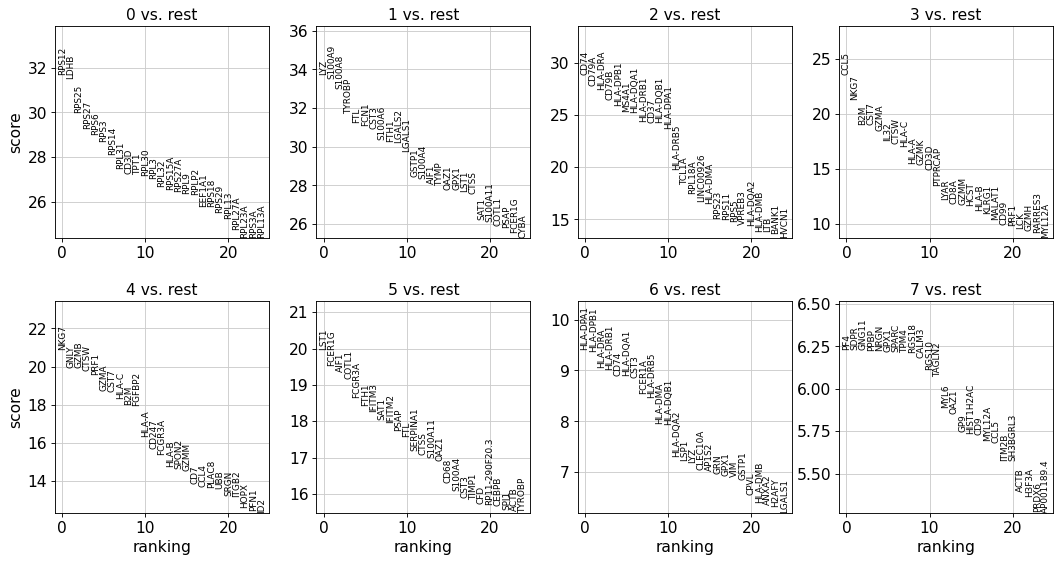

In [52]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [53]:
# save the results
adata.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by Natranos et al. (2018). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. Clark et al. (2014) has more details.

ranking genes
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
    finished (0:00:12)


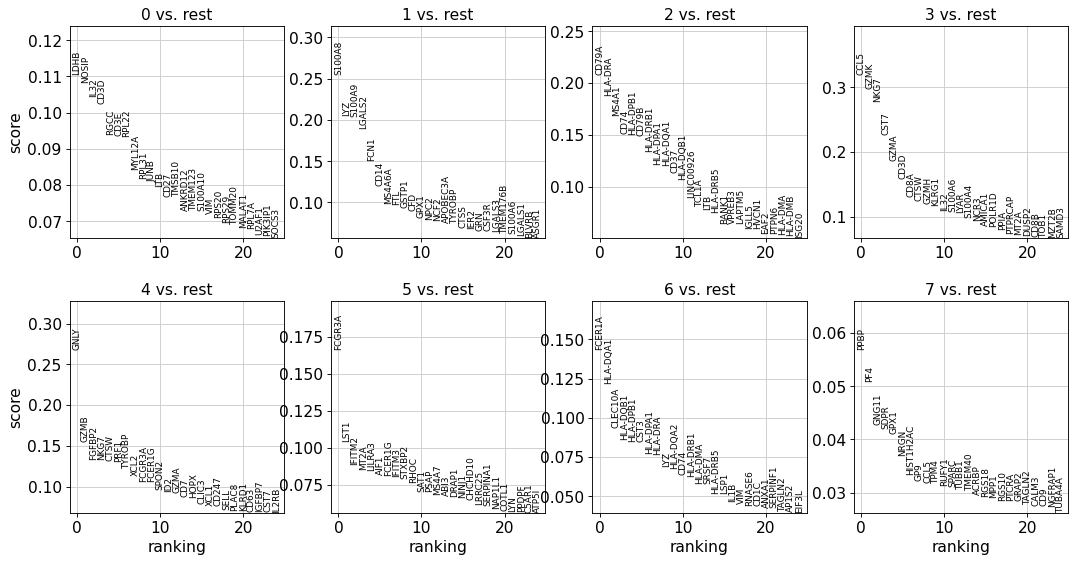

In [54]:
sc.tl.rank_genes_groups(adata, "leiden", method="logreg")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

With the exceptions of IL7R, which is only found by the t-test and FCER1A, which is only found by the other two appraoches, all marker genes are recovered in all approaches.

Let us also define a list of marker genes for later reference.

In [55]:
marker_genes = ["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14",
                "LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1",
                "FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"]

Reload the object that has been save with the Wilcoxon Rank-Sum test result.



In [56]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, …, 7 in a dataframe.

In [58]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head()

,0,1,2,3,4,5,6,7
0,RPS12,LYZ,CD74,CCL5,NKG7,LST1,HLA-DPA1,PF4
1,LDHB,S100A9,CD79A,NKG7,GNLY,FCER1G,HLA-DPB1,SDPR
2,RPS25,S100A8,HLA-DRA,B2M,GZMB,AIF1,HLA-DRA,GNG11
3,RPS27,TYROBP,CD79B,CST7,CTSW,COTL1,HLA-DRB1,PPBP
4,RPS6,FTL,HLA-DPB1,GZMA,PRF1,FCGR3A,CD74,NRGN


Get a table with the scores and groups

In [59]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame({
    group + "_" + key[:1]: result[key][group]
    for group in groups for key in ["names", "pvals"]}).head()

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS12,4.685107e-220,LYZ,7.634876e-249,CD74,3.043536e-182,CCL5,4.293729e-122,NKG7,1.203971e-96,LST1,1.322111e-88,HLA-DPA1,5.422417e-21,PF4,4.722886e-10
1,LDHB,3.803722e-218,S100A9,4.626358e-246,CD79A,6.860832e-170,NKG7,4.067448e-100,GNLY,1.257170e-88,FCER1G,6.259712e-85,HLA-DPB1,7.591860e-21,SDPR,4.733899e-10
2,RPS25,1.835304e-197,S100A8,1.622835e-238,HLA-DRA,8.389292e-166,B2M,2.717535e-80,GZMB,1.429027e-88,AIF1,1.348814e-83,HLA-DRA,1.306768e-19,GNG11,4.733899e-10
3,RPS27,4.891486e-188,TYROBP,2.957652e-220,CD79B,1.171444e-153,CST7,4.485171e-80,CTSW,4.144726e-87,COTL1,5.974694e-82,HLA-DRB1,1.865104e-19,PPBP,4.744938e-10
4,RPS6,6.839257e-185,FTL,2.479195e-214,HLA-DPB1,6.167786e-148,GZMA,7.019048e-76,PRF1,1.692100e-85,FCGR3A,1.392377e-77,CD74,5.853161e-19,NRGN,4.800511e-10


Compare to a single cluster

ranking genes
    finished (0:00:01)


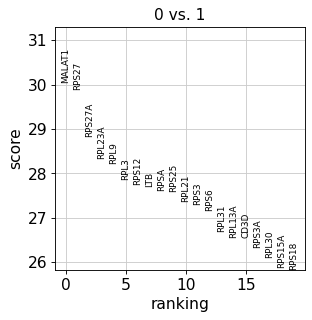

In [60]:
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

If we want a more detailed view for a certain group, use sc.pl.rank_genes_groups_violin.

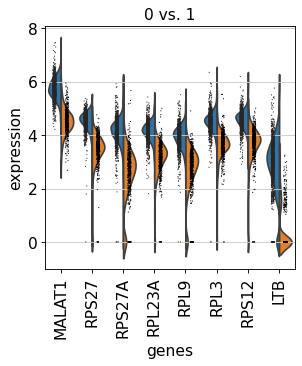

In [61]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

Reload the object with the computed differential expression (i.e. DE via a comparison with the rest of the groups):

In [62]:
adata = sc.read(results_file)

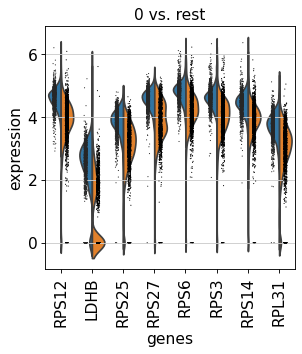

In [63]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

If you want to compare a certain gene across groups, use the following.

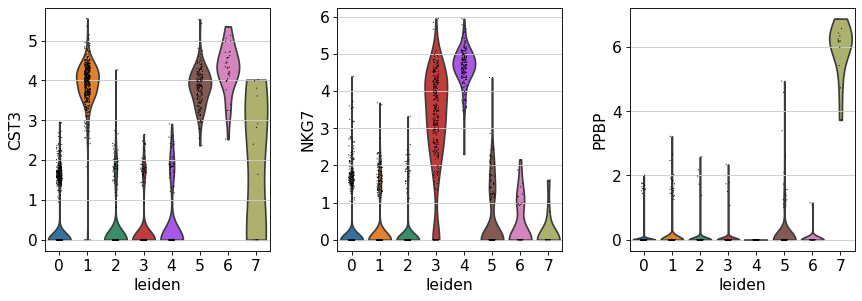

In [64]:
sc.pl.violin(adata, ["CST3", "NKG7", "PPBP"], groupby="leiden")

Actually mark the cell types

In [66]:
new_cluster_names = ["CD4 T", "CD14 Monocytes",
                     "B", "CD8 T",
                     "NK", "FCGR3A Monocytes",
                     "Dendritic", "Megakaryocytes"]

adata.rename_categories("leiden", new_cluster_names)

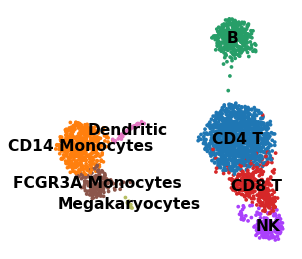

In [67]:
sc.pl.umap(adata, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf")

Now that we annotated the cell types, let us visualize the marker genes.

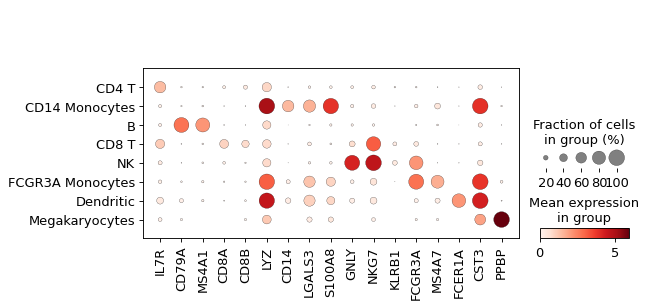

In [68]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden")

There is also a very compact violin plot

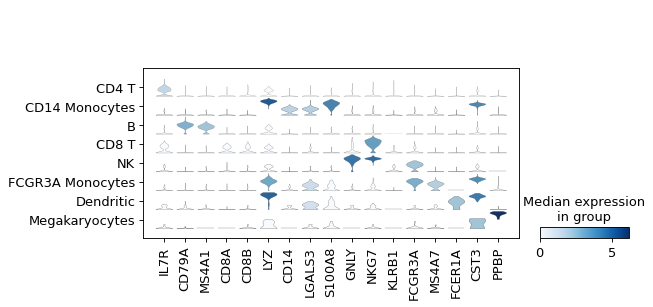

In [69]:
sc.pl.stacked_violin(adata, marker_genes, groupby="leiden", rotation=90)

During the course of this analysis, the AnnData accumlated the following annotations.

In [70]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Get a rough overview of the file using h5ls, which has many options. The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations in adata.raw.

In [71]:
adata.raw.to_adata().write('pbmc3k_withoutX.h5ad')

If you want to export to “csv”, you have the following options:

- Export single fields of the annotation of observations
```
adata.obs[['n_counts', 'louvain_groups']].to_csv(
     'pbmc3k_corrected_louvain_groups.csv')
```
- Export single columns of the multidimensional annotation
```
adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
    'pbmc3k_corrected_X_pca.csv')
```

- Or export everything except the data using `.write_csvs`.

Set `skip_data=False` if you also want to export the data.

```
adata.write_csvs(results_file[:-5])
```